# Cell counting

We will examine the use of U-Nets to perform cell counting, a crucial task to determine the number of cells in cell cultures before and after treatment.

## Cell nuclei images

We used image set BBBC039v1 Caicedo et al. 2018, available from the Broad Bioimage Benchmark Collection https://data.broadinstitute.org/bbbc/BBBC039/ [Ljosa et al., Nature Methods, 2012].

This data set has a total of 200 fields of view of nuclei captured with fluorescence microscopy using the Hoechst stain. The collection has around 23,000 single nuclei manually annotated to establish a ground truth collection for segmentation evaluation.

The images are stored as TIFF files with 520x696 pixels at 16 bits. Ground truth annotations are stored as PNG files encoding masks of independent nuclei.
We download the data from the DeepTrackAI repository `cell_counting_dataset`. We use `Deeptrack2.1` to define sources where to load the data from during training and test.

In [1]:
import os
import deeptrack as dt

if not os.path.exists("cell_counting_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/cell_counting_dataset")

raw_path = os.path.join("cell_counting_dataset","cell nuclei", "images")
label_path = os.path.join("cell_counting_dataset","cell nuclei", "masks")

raw_paths = dt.sources.ImageFolder(root=raw_path)
label_paths = dt.sources.ImageFolder(root=label_path)

sources = dt.sources.Source(raw=raw_paths, label=label_paths)

print(f"{len(sources)} images")

200 images


We write a pipeline to load the images and the corresponding masks and display a few examples, with the corresponding histograms. 

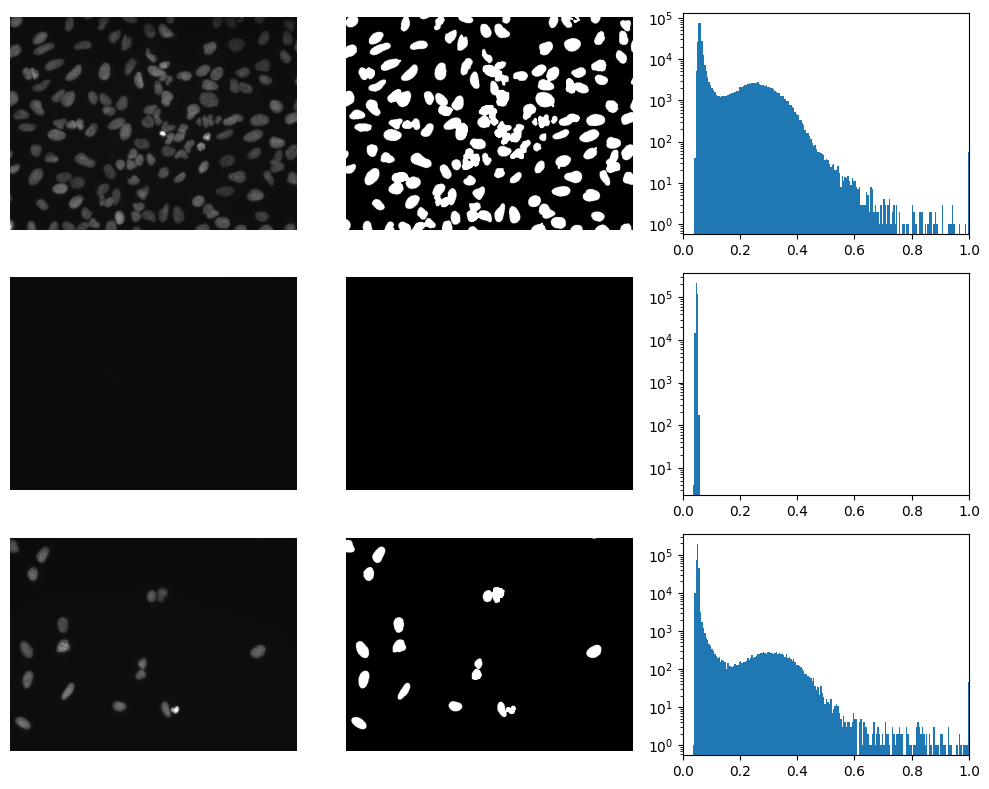

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader


im_pipeline = (
    dt.LoadImage(sources.raw.path)
    >> dt.Divide(3000)
    >> dt.Clip(0, 1)
    >> dt.AsType("float")
)

lab_pipeline = dt.LoadImage(sources.label.path)[..., :1] >> dt.AsType("float")

pipeline = (
    (im_pipeline & lab_pipeline)
    >> dt.Crop(crop=(512, 688, None), corner=(0, 0))
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

test_dataset = dt.pytorch.Dataset(pipeline, sources)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

fig, axes = plt.subplots(3, 3, figsize=(10, 8))

idxs = np.random.choice(len(test_dataset), 3, replace=False)
for i, idx in enumerate(idxs):
    image, mask = test_dataset[idx]
    axes[i, 0].imshow(image.permute(1, 2, 0), vmin=0, vmax=1, cmap="gray")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(mask.permute(1, 2, 0), vmin=0, vmax=1, cmap="gray")
    axes[i, 1].axis("off")
    axes[i, 2].hist(np.array(image).flatten(), bins=200, range=(0, 1))
    axes[i, 2].set_yscale("log")
    axes[i, 2].set_xlim([0, 1])
plt.tight_layout()
plt.show()

To count the number of cells, we will use the number of connected components of the segmentaion mask, i.e. groups of adjacents pixels with the same value. 

For this, we can first _label_ the mask by assigning a different integer label to each component. We will verify it on the images we just displayed.

In [3]:
from skimage.morphology import label, area_closing, isotropic_erosion


def count_connected_components(mask):
    labeled_mask = label(mask)
    return labeled_mask.max()


for i, idx in enumerate(idxs):
    _, mask = test_dataset[idx]
    print("Number of cells = " + str(count_connected_components(mask)))

Number of cells = 165
Number of cells = 0
Number of cells = 19


## Simulations

We will use ``Deeptrack2.1`` to simulate fluorescently labeled cell nuclei, so to have a large labeled training dataset.

In [4]:
training_image_size = 256

def random_ellipse_radius():
    desired_ellipse_area = (np.random.uniform(3, 4)) ** 2
    desired_radius_ratio = np.random.uniform(1, 1.5)
    major_axis_radius = np.sqrt(desired_ellipse_area) * desired_radius_ratio
    minor_axis_radius = np.sqrt(desired_ellipse_area) / desired_radius_ratio
    z_radius = np.sqrt(desired_ellipse_area) * np.random.uniform(0.2, 0.4)
    return (major_axis_radius, minor_axis_radius, z_radius) * dt.units.um

ellipse = dt.Ellipsoid(
    radius=random_ellipse_radius,
    intensity=lambda: np.random.uniform(0.5, 1.5),
    position=lambda: np.random.uniform(5, training_image_size - 5, size=2),
    rotation=lambda: np.random.uniform(0, 2 * np.pi),
)

optics = dt.Fluorescence(
    resolution=1e-6,
    magnification=6,
    wavelength=400e-9,
    NA=lambda: np.random.uniform(0.9, 1.1),
    output_region=(0, 0, training_image_size, training_image_size),
)

synthetic_cell = (
    (ellipse ^ (lambda: np.random.randint(5, 10)))
    >> dt.Pad(px=(10, 10, 10, 10), keep_size=False)                                ### pad the cells to make the elastic transformation not get cropped
    >> dt.ElasticTransformation(alpha=100, sigma=10, order=1) 
    >> dt.CropTight()                                                              ### crop the padded cells to the original size. 
)

In [5]:
# Create a mask of the synthetic cell. This will be used to edge bleed from the blurred structural noise
synthetic_cell_mask = synthetic_cell > 0

# Add structural noise to the synthetic cell
long_range_noise = (
    synthetic_cell 
    >> dt.Poisson(snr=lambda: 0.2) 
    >> dt.GaussianBlur(sigma=3.5)
)

short_range_noise = (
    synthetic_cell 
    >> dt.Poisson(snr=lambda: 1.0) 
    >> dt.GaussianBlur(sigma=1.5)
) 

random_range_nosie = (
    synthetic_cell 
    >> dt.Poisson(snr=lambda: np.random.uniform(0.5, 1.5))
    >> dt.GaussianBlur(sigma=lambda: np.random.uniform(0.75, 1.5))
) 

noised_synthetic_cell = synthetic_cell_mask * (
    long_range_noise + short_range_noise + random_range_nosie
) / 3 

In [6]:
# Create a non-overlapping version of the synthetic cell
non_overlapping_cells = dt.NonOverlapping(noised_synthetic_cell, 
                                          min_distance=-6)                                  ### min_distance=-6 to allow the cells overlap a little bit

image_pipeline = (
    optics(non_overlapping_cells)
    >> dt.Gaussian(sigma=lambda: np.random.uniform(0, 0.1))
    >> dt.Divide(lambda: np.random.uniform(14, 20))
    >> dt.Add(lambda: np.random.uniform(-0.05, 0.15))
    >> dt.Clip(0, 1)
    >> dt.AsType("float")
)

We also need to provide target images that will be used to quantify the number of cells. As a first approximation, we simply use the segmentation map. 


In [7]:
def get_mask(radius):
    def inner(mask):
        mask = np.sum(mask, -1, keepdims=True) > 0
        mask = np.pad(mask, [(1, 1), (1, 1), (0, 0)], mode="constant")
        mask = isotropic_erosion(mask, radius=radius)
        mask = mask[1:-1, 1:-1]
        return mask
    return inner


label_pipeline = (
    non_overlapping_cells
    >> dt.SampleToMasks(get_mask, radius=6,
                        output_region=optics.output_region,
                        merge_method="or")
    >> dt.AsType("float")
)

image_and_gt_pipeline = (
    (image_pipeline & label_pipeline)
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

train_dataset = dt.pytorch.Dataset(image_and_gt_pipeline, 
                                   length=640, 
                                   replace=0.01) 

We display a few examples of simulated images with the corresponding masks and histograms.

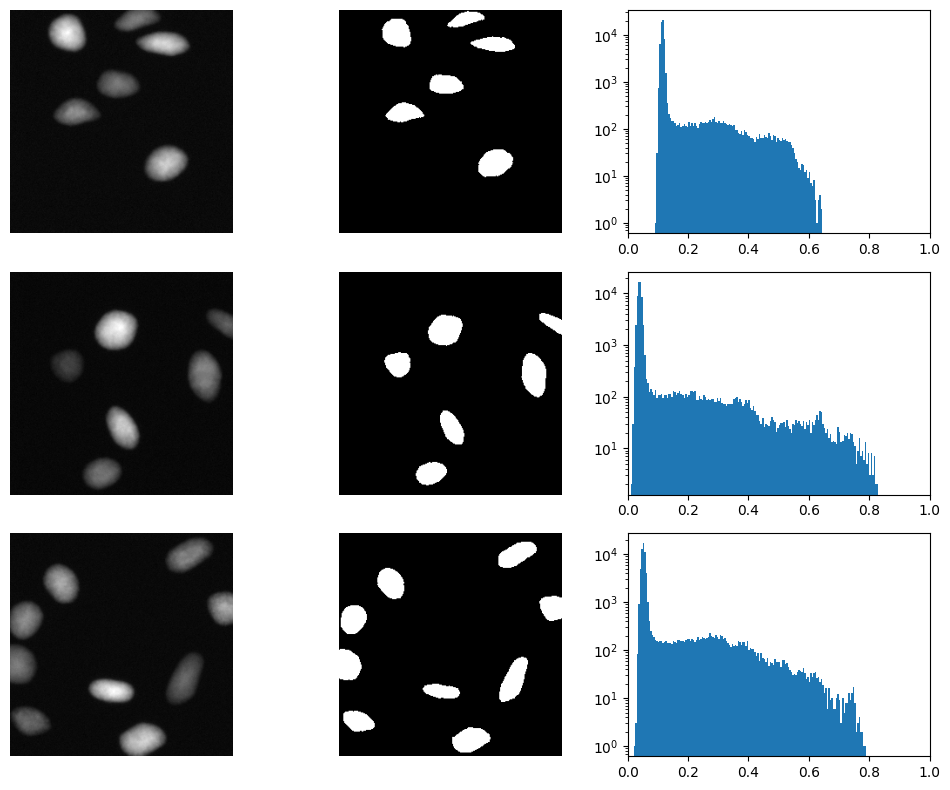

In [8]:
_, axes = plt.subplots(3, 3, figsize=(10, 8))

for i in range(3):
    image, mask = train_dataset[i]
    axes[i, 0].imshow(image.permute(1, 2, 0), cmap="gray")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(mask.permute(1, 2, 0), cmap="gray")
    axes[i, 1].axis("off")
    axes[i, 2].hist(np.array(image).flatten(), bins=200, range=(0, 1))
    axes[i, 2].set_xlim([0, 1])
    axes[i, 2].set_yscale("log")
plt.tight_layout()
plt.show()

## UNet

We will use a UNet to segment the cells.

In [9]:
import deeplay as dl

unet = dl.UNet2d(
    in_channels=1,
    channels=[16, 32, 64],
    out_channels=1,
)
print(unet)

UNet2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=16)
      )
      (1): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=32)
      )
      (2): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (3): PoolLayerActivationNormalization(
        (pool):

We use the binary crossentropy loss

In [10]:
import torchmetrics as tm
from torch.nn import BCEWithLogitsLoss

unet_regressor = dl.Regressor(
    model=unet,
    loss=BCEWithLogitsLoss(),
    optimizer=dl.Adam(),
).create()

We train the network for 50 epochs.

In [11]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
unet_trainer = dl.Trainer(max_epochs=200, accelerator="auto")
unet_trainer.fit(unet_regressor, train_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
C:\Users\GU\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.se

Epoch 199: 100%|██████████| 80/80 [00:05<00:00, 15.76it/s, v_num=2022, train_loss_step=0.00926, train_loss_epoch=0.009]  

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 80/80 [00:05<00:00, 15.70it/s, v_num=2022, train_loss_step=0.00926, train_loss_epoch=0.009]


Let's first test the network on the simulated data.

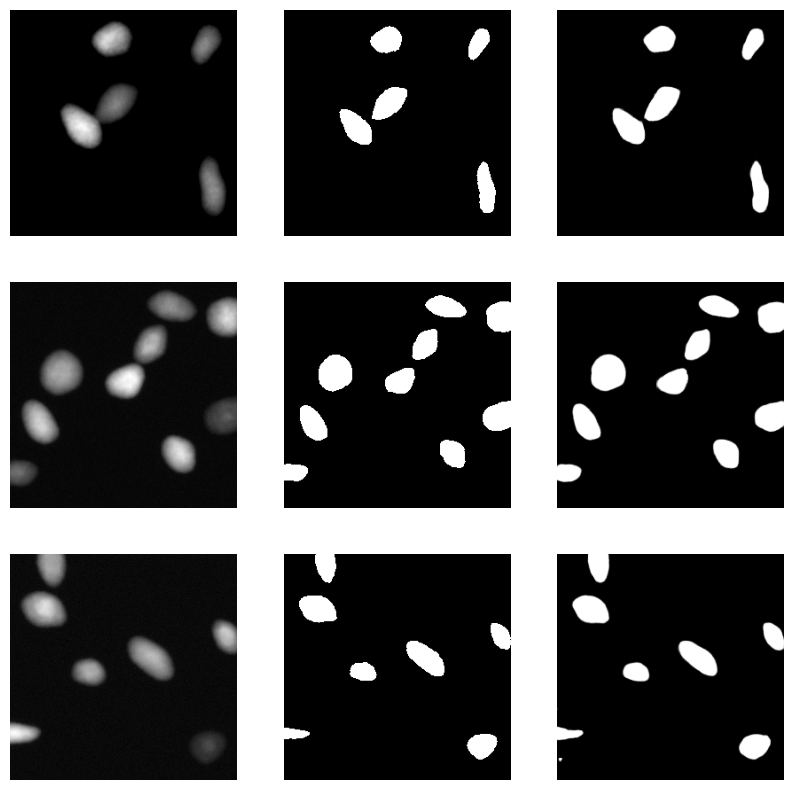

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    raw_image, mask = image_and_gt_pipeline.update()()
    pred = unet_regressor(raw_image.unsqueeze(0)).sigmoid().detach()
    axes[i, 0].imshow(raw_image.squeeze(), cmap="gray")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(mask.squeeze(), cmap="gray")
    axes[i, 1].axis("off")
    axes[i, 2].imshow(pred.squeeze(), cmap="gray")
    axes[i, 2].axis("off")

plt.show()

We'll apply it to all the images in the test set and calculate true and predicted number of cells.

In [13]:
images, labels, preds = [], [], []
unet_regressor.to("cuda")
for im, lab in test_loader:
    images.append(im)
    labels.append(lab)
    pr = unet_regressor(im.to("cuda")).detach()
    pr = torch.nn.functional.sigmoid(pr).cpu()
    preds.append(pr)
images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
preds = torch.cat(preds, dim=0)

true_count = [count_connected_components(l.squeeze()) for l in labels]
pred_count = [count_connected_components(p.squeeze() > 0.995) for p in preds]

pred_count = np.array(pred_count)
true_count = np.array(true_count)


We calculate MAE and MPE and display the results in a scatterplot.

MAE: 10.61
MPE: 0.09


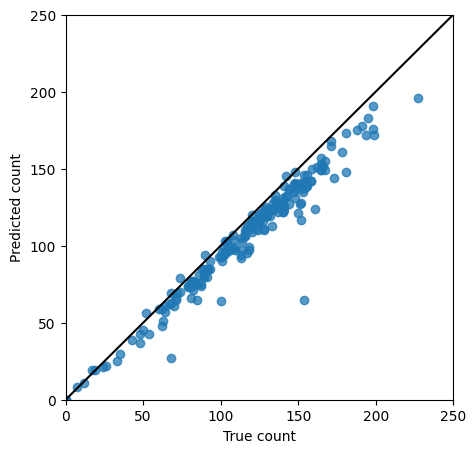

In [14]:
mae = abs(pred_count - true_count).mean()
nonzeros = true_count > 0
mpe = (abs(pred_count[nonzeros] - true_count[nonzeros]) / (true_count[nonzeros])).mean()

print(f"MAE: {mae:.2f}")
print(f"MPE: {mpe:.2f}")

plt.figure(figsize=(5, 5))
plt.scatter(true_count, pred_count, alpha=0.75)
plt.axline([0, 0], [1, 1], color="black")
plt.xlabel("True count")
plt.ylabel("Predicted count")
plt.xlim(0, 250)
plt.ylim(0, 250)
plt.show()

...and visually check the predictions.

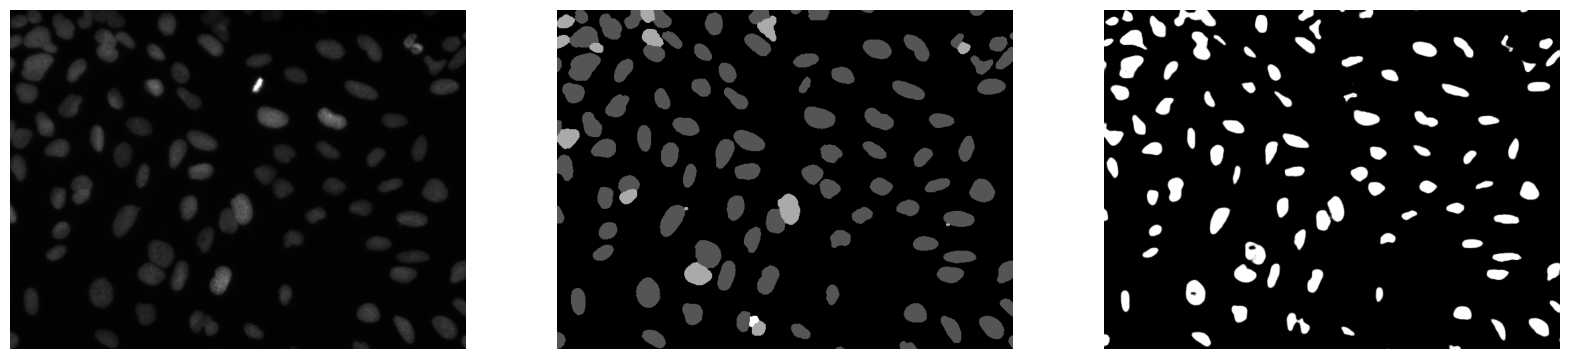

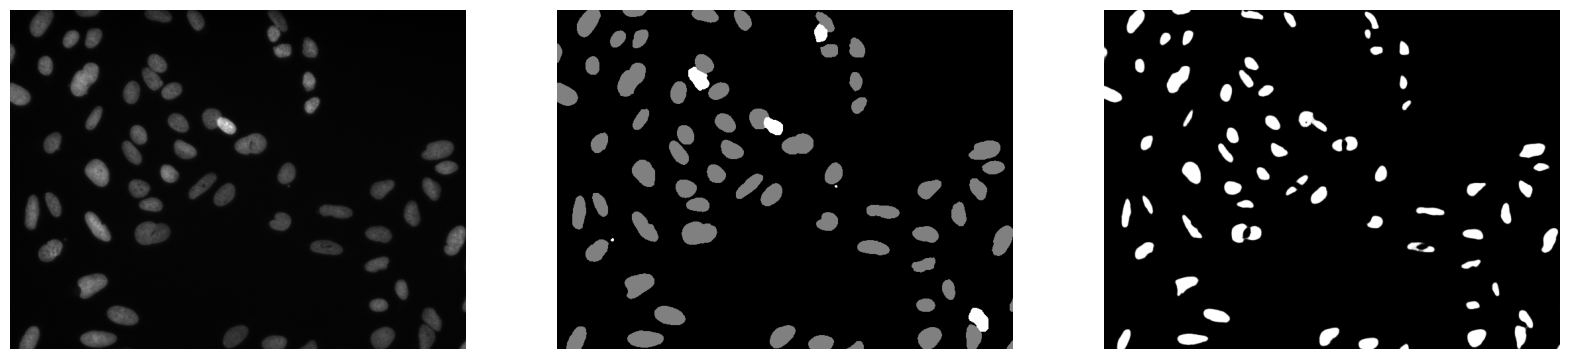

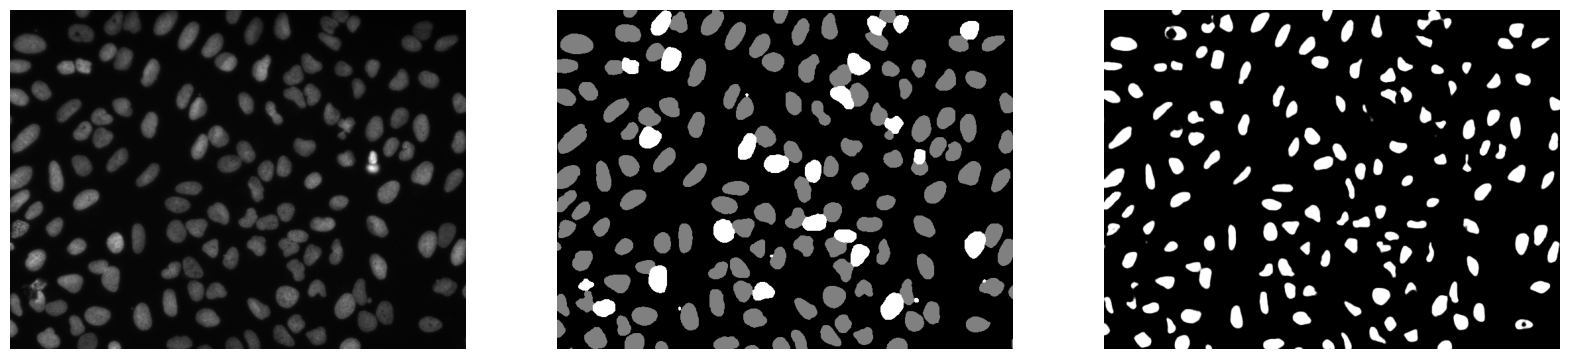

In [15]:
for i in range(3):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(labels[i].squeeze(), cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(preds[i].squeeze(), cmap="gray")
    plt.axis("off")
    plt.show()